# Response comparison notebook

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from openTSNE import TSNE
from keras.models import load_model

import sys
sys.path.append("../WPRAutoencoders")
from Utilities import normalize, calc_derivative
from WPRGenerator import WPRGenerator

In [2]:
encoding_model = load_model("../models/trained_model.h5")
# load training data
df = pd.read_csv("../dataset/20000_well_tests.csv")
# transmissibility feature creation
df["trans"] = df["k"]*df["h"]/df["visc"]

125/125 [==============================] - 0s 1ms/step


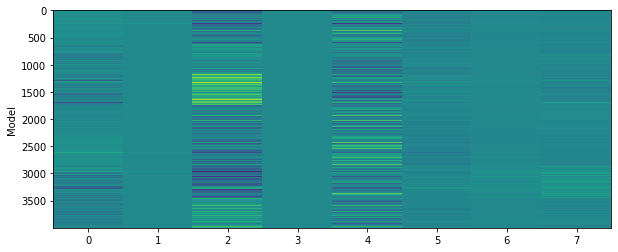

In [3]:
# Get df values
X = df.values
X[X==0] = 1e-5
X_train_base, X_test_base = train_test_split(X, test_size=0.2, random_state=100, shuffle=True)

X_train_base, X_test_base = train_test_split(X, test_size=0.2, random_state=100, shuffle=True)

# Create and normalize train datasets
norm_log_p_train = normalize(np.log(X_train_base[:, 35:55].astype(float)))
norm_log_dp_train = normalize(np.log(X_train_base[:, 55:75].astype(float)))
X_train_1 = np.hstack([norm_log_p_train, norm_log_dp_train])

# Create and normalize test datasets
norm_log_p_test = normalize(np.log(X_test_base[:, 35:55].astype(float)))
norm_log_dp_test = normalize(np.log(X_test_base[:, 55:75].astype(float)))
X_test_1 = np.hstack([norm_log_p_test, norm_log_dp_test])

test_df = pd.DataFrame(X_test_base)
test_df = test_df.sort_values(0)
X_transmissibility = test_df.values[:, -1].astype(float)
X_transmissibility = 200*(X_transmissibility - np.min(X_transmissibility))/(np.max(X_transmissibility) - np.min(X_transmissibility))

# Create and normalize test datasets
norm_log_p_validate = normalize(np.log(test_df.values[:, 35:55].astype(float)))
norm_log_dp_validate = normalize(np.log(test_df.values[:, 55:75].astype(float)))
X_validate_1 = np.hstack([norm_log_p_validate, norm_log_dp_validate])

data = encoding_model.predict(X_validate_1)

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_ylabel(f"Model")
ax.imshow(data, interpolation="nearest", aspect="auto")
ax.set_facecolor("white")

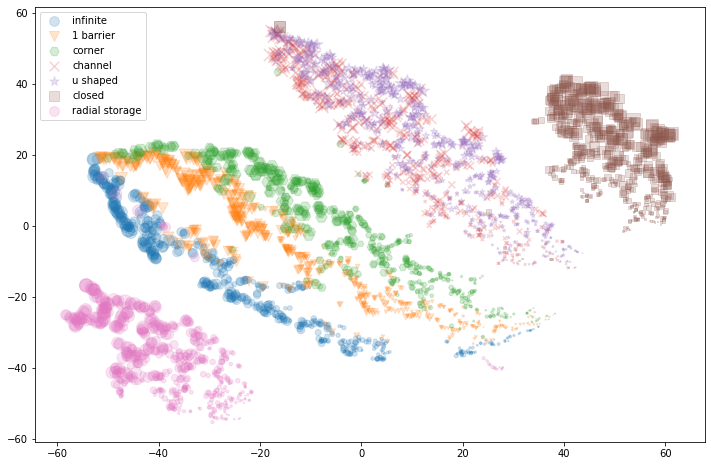

In [4]:
labels = test_df[0].values
embedding = TSNE(random_state=1).fit(data)

fig, ax = plt.subplots(1,1,figsize=(12,8))
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed", "radial storage"]
markers = ["o", "v", "H", "x", "*", "s", "o"]
for k,mdl in enumerate(models):
    ax.scatter(embedding[np.where(labels == mdl), 0], 
               embedding[np.where(labels == mdl), 1], 
               marker=markers[k], 
               alpha=0.2, 
               s=X_transmissibility[np.where(labels == mdl)],
               label=mdl)
    ax.legend()

## Sample case creation

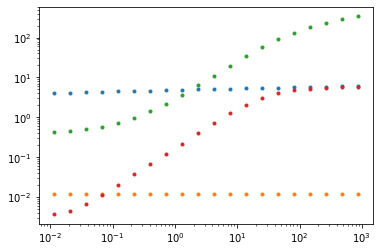

In [5]:
q_ref = 15.9
tk = np.logspace(-2.2,3.2,22)

# tk, k, por, h, ct, Bo, visc, q, skin, L1, L2, L3, L4, rw
case_1 = WPRGenerator(
    tk, 150, 0.2, 100, 1e-5, 1, 1, 300, 5, 1e6, 1e6, 1e6, 1e6, 0.108
)
dp_u_1 = case_1.create_dpu()
der_u_1 = calc_derivative(tk, dp_u_1/q_ref, 0.0)

case_2 = WPRGenerator(
    tk, 200, 0.2, 250, 1e-5, 1, 1, 300, -2, 50, 50, 50, 50, 0.108
)
dp_u_2 = case_2.create_dpu()
der_u_2 = calc_derivative(tk, dp_u_2/q_ref, 0.0)

tk = tk[1:-1]
dp_u_1 = dp_u_1[1:-1]
der_u_1 = der_u_1[1:-1]
dp_u_2 = dp_u_2[1:-1]
der_u_2 = der_u_2[1:-1]

plt.loglog(tk, dp_u_1, ".")
plt.loglog(tk, der_u_1, ".")
plt.loglog(tk, dp_u_2, ".")
plt.loglog(tk, der_u_2, ".")

dp_data = np.array([dp_u_1, dp_u_2])
der_data = np.array([der_u_1, der_u_2])

1/1 [==============================] - 0s 47ms/step


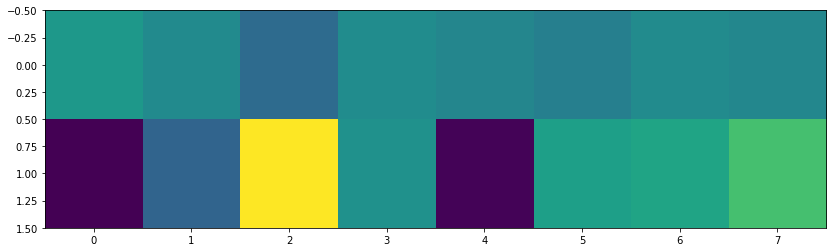

In [6]:
# Create and normalize test datasets
norm_log_p = normalize(np.log(dp_data))
norm_log_dp = normalize(np.log(der_data))
sample_test = [np.hstack([norm_log_p, norm_log_dp])]

sample_data = encoding_model.predict(sample_test)

fig, ax = plt.subplots(1,1,figsize=(14,4))
ax.imshow(sample_data, interpolation="nearest", aspect="auto")

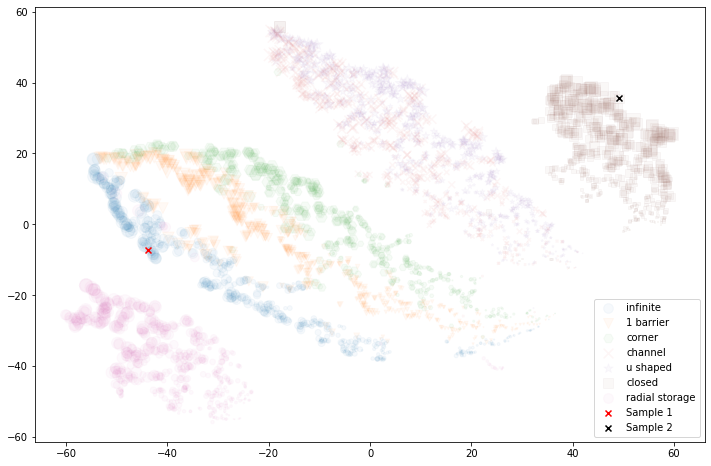

In [7]:
sample_embedding = embedding.transform(sample_data)

fig, ax = plt.subplots(1,1,figsize=(12,8))
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed", "radial storage"]
markers = ["o", "v", "H", "x", "*", "s", "o"]

for k,mdl in enumerate(models):
    ax.scatter(embedding[np.where(labels == mdl), 0], 
               embedding[np.where(labels == mdl), 1], 
               marker=markers[k], 
               alpha=0.04, 
               s=X_transmissibility[np.where(labels == mdl)],
               label=mdl)

ax.scatter(sample_embedding[0,0], sample_embedding[0,1], label="Sample 1", marker="x", color="red")
ax.scatter(sample_embedding[1,0], sample_embedding[1,1], label="Sample 2", marker="x", color="black")
ax.legend()